In [ ]:
!pip install opendatasets

In [2]:
import opendatasets as od
import numpy as np
import pandas as pd

In [3]:
od.download('https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection')

100%|██████████| 3.30M/3.30M [00:01<00:00, 2.56MB/s]

In [24]:
df = pd.read_json("/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [40]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

In [26]:
sentences=[]
labels=[]
for idx,row in df.iterrows():
  sentences.append(row['headline'])
  labels.append(row['is_sarcastic'])

In [27]:
VOCAB_SIZE=10000
EMBEDDING_DIM=256
MAX_LENGTH=100
trunc_type='post'
padding_type='post'
oov_token='<OOV>'
training_size=20000

In [28]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [29]:
tokenizer=Tokenizer(num_words=VOCAB_SIZE,oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=MAX_LENGTH, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=MAX_LENGTH, padding=padding_type, truncating=trunc_type)

In [30]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = False ,unit_forget_bias=True, implementation=2)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

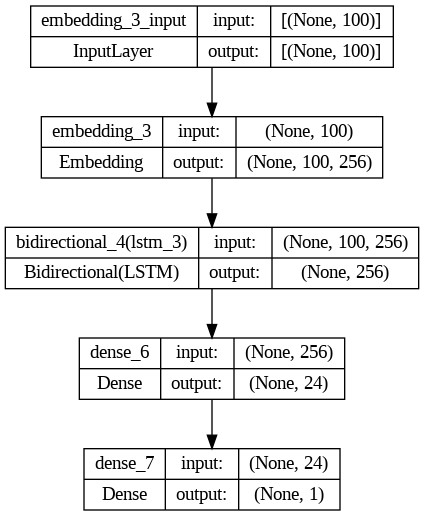

In [41]:
plot_model(model, show_shapes=True)

In [32]:
model.load_weights('model_weights1.h5')

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 256)          2560000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 24)                6168      
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 2,960,433
Trainable params: 2,960,433
Non-trainable params: 0
_________________________________________________________________


In [34]:
num_epochs = 5
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/5
625/625 - 257s - loss: 0.4678 - accuracy: 0.7760 - val_loss: 0.3162 - val_accuracy: 0.8595 - 257s/epoch - 411ms/step
Epoch 2/5
625/625 - 255s - loss: 0.2013 - accuracy: 0.9187 - val_loss: 0.3247 - val_accuracy: 0.8631 - 255s/epoch - 409ms/step
Epoch 3/5
625/625 - 232s - loss: 0.0883 - accuracy: 0.9683 - val_loss: 0.4424 - val_accuracy: 0.8558 - 232s/epoch - 371ms/step
Epoch 4/5
625/625 - 241s - loss: 0.0422 - accuracy: 0.9861 - val_loss: 0.5103 - val_accuracy: 0.8481 - 241s/epoch - 385ms/step
Epoch 5/5
625/625 - 241s - loss: 0.0226 - accuracy: 0.9920 - val_loss: 0.6940 - val_accuracy: 0.8386 - 241s/epoch - 385ms/step


In [35]:
model.save_weights('model_weights2.h5')

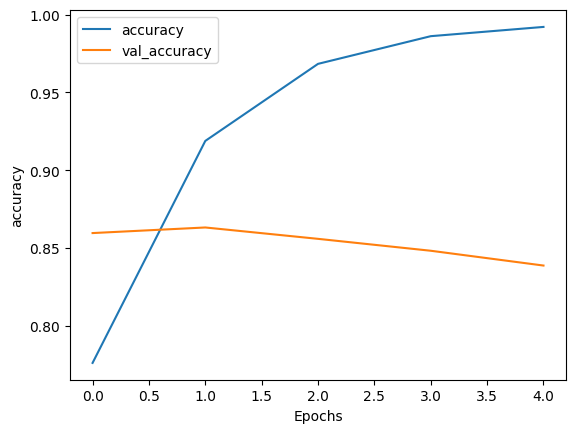

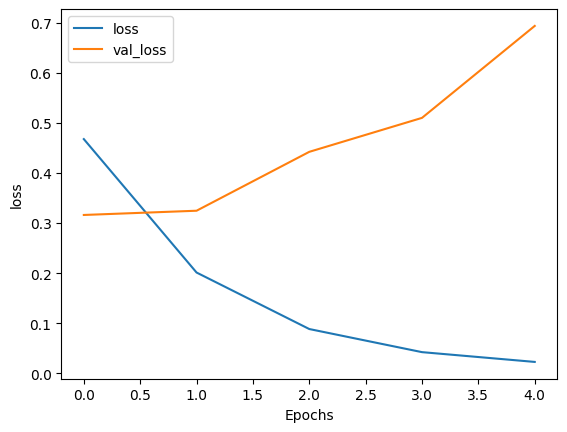

In [36]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [39]:
# sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sentence=[df.iloc[4]['headline']]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=MAX_LENGTH, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 131ms/step
[[0.9999987]]
